This notebook concisely preprocesses the data and trains + evaluates the chosen models.

In [1]:
# load relevant packages
import pandas as pd
import numpy as np
# load additional functions (outsourced for cleaner Notebook)
import additional_functions as af

# Training & Evaluating Models

Based on what I found out and decided on in the data exploration, I will now implement models and evaluate/compare them.

To recap:
- 3 models to compare:
    - original features (with one-hot encoded coordinates, days, and months)
    - engineered feature combination (calendar quarters -- weekend)
    - engineered feature combination (calendar quarters -- weekend adjacent))
- preprocessing:
    - make categorical values (coordinates, months, days) numeric
    - add binary features for calender quarters and weekend (adjacancy) 
    - drop ISI outlier datapoint
    - define FFMC cut-off threshold (80) and drop datapoints below the threshold
- normalisation:
    - z-score normalisation for FFMC, DMC, DC, ISI, temp, RH, wind
    - log(1+feature) transformation for rain, area

504 data points are by far not enought to train a neural network. Because there are relatively few features (m $\times$ m matrix would still fit into memory) I have decided to implement a Ridge Regression. I will use nested cross-validation for evaluation and model selection / hyperparameter tuning.

## Preprocessing

In [2]:
# load data as dataframe
data_df = pd.read_csv('data/fires.csv')

# make categorical values numeric and add binary quarters/weekend features
data_df = af.make_numeric(data_df)
# drop ISI and FFMC "outliers"
data_df = af.drop_outliers(data_df)

z-score normalisation can be performed within scikit-learns Ridge method. This is great for avoiding data leakage.

In [3]:
# save true area seperately
true_area = data_df['area'].copy(deep=True)

#to_normalise = ['FFMC','DMC','DC','ISI','temp','RH','wind','rain']
to_transform = ['rain','area']
# log transform area + rain
for feature in to_transform:
    data_df[feature] = np.log1p(data_df[feature])

# select the different relevant feature columns for the different models
# original features, calender quarters + weekend, calender quarters + weekend adjacent
original_df, qw_df, qwa_df = af.select_features(data_df)
print(f"feature selection original has shape {original_df.shape}\nfeature selection calender quarters + weekend has shape {qw_df.shape}\nfeature selection calender quarters + weekend adjacent has shape {qwa_df.shape}")

feature selection original has shape (504, 44)
feature selection calender quarters + weekend has shape (504, 30)
feature selection calender quarters + weekend adjacent has shape (504, 30)


In [4]:
print(f"Scale range of log transformed area: {data_df['area'].min()} to {data_df['area'].max()}")

Scale range of log transformed area: 0.0 to 6.995619625423205


First, I'll set up a very simple baseline that just predicts the mean value of the area distribution.
## Simple Baseline

In [5]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# prepare scorer for MSE
mse_scorer = make_scorer(mean_squared_error)

# dict for first simple comparison
simple_comparison = dict()

baseline = DummyRegressor(strategy='mean')
# split target (-> area) from attributes
X, y = af.get_target(original_df)
mse = cross_val_score(baseline,X,y, scoring=mse_scorer)
mse = mse.mean()
simple_comparison['baseline'] = {'MSE': mse, 'RMSE': np.sqrt(mse)}
print(f"Mean Squared Error: {mse}\nRoot Mean Squared Error: {np.sqrt(mse)}")

Mean Squared Error: 2.199647222104289
Root Mean Squared Error: 1.4831207712469976


The baseline has a high MSE value if we take into consideration that the range of log transformed values goes from 0.0 to 6.9956.

## Ridge Regression

First, I'll start with comparing the different feature sets with the default Ridge parameters. For a better estimation of the regularised empirical risk I perform a simple 10-fold cross-validation on each of the models and average the scores of each fold.

In [6]:
from sklearn.linear_model import Ridge

for nr, feature_selection in enumerate([original_df, qw_df, qwa_df]): 
    # split target (-> area) from attributes
    X, y = af.get_target(feature_selection)
    model = Ridge(normalize=True)
    # perform cross-validation
    mse = cross_val_score(model, X, y, scoring=mse_scorer, cv=10)
    mse = mse.mean()
    # add reg.emp. risk to dict overview
    simple_comparison[nr] = {'MSE': mse, 'RMSE': np.sqrt(mse)}
    print(f"Model {nr} -- MSE: {mse}, RMSE: {np.sqrt(mse)}")

Model 0 -- MSE: 2.3291846775892635, RMSE: 1.5261666611446023
Model 1 -- MSE: 2.2795728047050927, RMSE: 1.5098254219296656
Model 2 -- MSE: 2.2741805620272646, RMSE: 1.5080386473917917


## First comparison of baseline and simple models

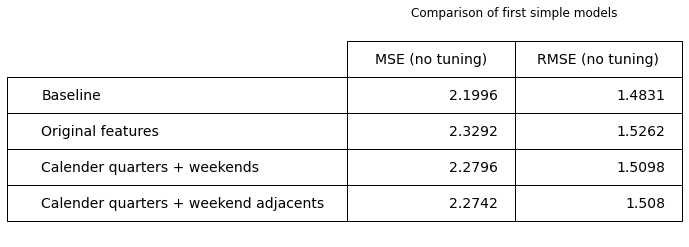

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axis('off')
plt.title("Comparison of first simple models")
table = ax.table(cellText=[[round(simple_comparison['baseline']['MSE'],4),round(simple_comparison['baseline']['RMSE'],4)],
    [round(simple_comparison[0]['MSE'],4),round(simple_comparison[0]['RMSE'],4)],[round(simple_comparison[1]['MSE'],4),round(simple_comparison[1]['RMSE'],4)], 
    [round(simple_comparison[2]['MSE'],4),round(simple_comparison[2]['RMSE'],4)]], colLabels=['MSE (no tuning)','RMSE (no tuning)'] , 
    rowLabels=['Baseline', 'Original features', 'Calender quarters + weekends', 'Calender quarters + weekend adjacents'], loc='center')
table.set_fontsize(14)
table.scale(1,3)

All simple ridge regression models perform even (slightly) worse than the baseline; of all the ridge regression models the one with the feature combination of calender quarters and weekends + adjacent days binary features performed best. 

To get a feeling of the simple ridge regression predictions I will visualise how such models would predict area for their training data. 

Original features


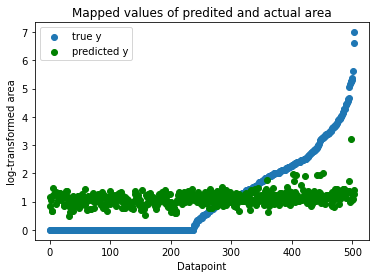

Calender quarters + weekends


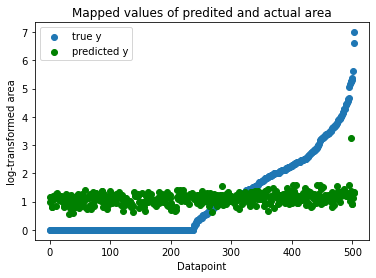

Calender quarters + weekend adjacents


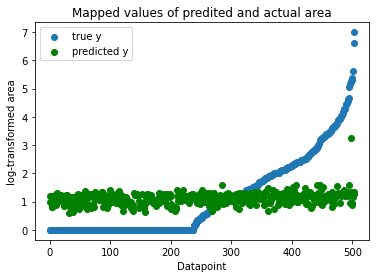

In [8]:
for nr, feature_selection in enumerate([original_df, qw_df, qwa_df]): 
    # split target (-> area) from attributes
    X, y = af.get_target(feature_selection)
    # fit model with feature selection, predict
    model = Ridge(normalize=True).fit(X,y)
    y_preds = model.predict(X) 
    # print which model we're at
    if nr == 0:
        print('Original features')
    elif nr == 1:
        print('Calender quarters + weekends')
    else:
        print('Calender quarters + weekend adjacents')
    af.show_plot(predictions=y_preds, target=y)

All ridge regression models seem to predict a pretty constant value, prossibly close to the mean. They perform this bad even though these are known datapoints! This is pretty shocking.

In [9]:
(true_area == 0).sum()

238

It was already pretty visible in the data exploration and above in numbers: the dataset, even though it contains only instances where fires occurred, has a high proportion of cases were 0 ha of the forest were burnt. This is nearly half of all datapoints. However, leaving them out in order to be able to fit a more telling model would reduce the already very low number of datapoints even more drastically.

Just to get a first impression of whether non-linear approaches could perform better on this dataset / are better fit for these data I'll implement a very simple random forest regressor.

## Comparison To Simple Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X, y = af.get_target(original_df)

forest = RandomForestRegressor(random_state=43)
mse = cross_val_score(forest, X, y, scoring=mse_scorer, cv=10)
mse = mse.mean()
simple_comparison['forest'] = {'MSE': mse, 'RMSE': np.sqrt(mse)}

print(f'MSE: {mse}, RMSE: {np.sqrt(mse)}')

MSE: 2.8462133880382936, RMSE: 1.6870724311772431


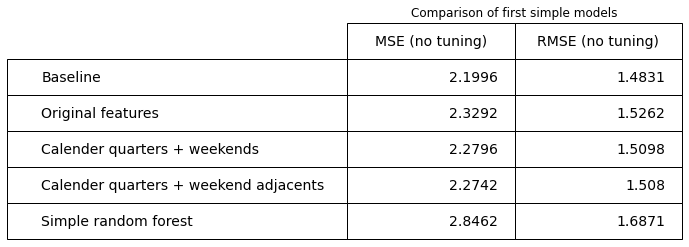

In [11]:
fig, ax = plt.subplots()
ax.axis('off')
plt.title("Comparison of first simple models")
table = ax.table(cellText=[[round(simple_comparison['baseline']['MSE'],4),round(simple_comparison['baseline']['RMSE'],4)],
    [round(simple_comparison[0]['MSE'],4),round(simple_comparison[0]['RMSE'],4)],[round(simple_comparison[1]['MSE'],4),round(simple_comparison[1]['RMSE'],4)], 
    [round(simple_comparison[2]['MSE'],4),round(simple_comparison[2]['RMSE'],4)],[round(simple_comparison['forest']['MSE'],4),round(simple_comparison['forest']['RMSE'],4)]], 
    colLabels=['MSE (no tuning)','RMSE (no tuning)'], rowLabels=['Baseline', 'Original features', 'Calender quarters + weekends', 'Calender quarters + weekend adjacents', 'Simple random forest'], loc='center')
table.set_fontsize(14)
table.scale(1,3)

Just using the default settings actually leads to an even worse result than any of the feature combinations for the simple ridge regression. Of course, this could be due to overfitting that could be "remedied" with setting a maximum depth etc, but for now I will continue with hyperparameter tuning / nested cross validation for the Ridge Regression, because those would be the steps I would like to take in order to ensure a good model selection and reasonable empirical risk estimation if I were to actually present a prediction model to the nature park. (Ignoring the fact that the data seems to be too bad to actually get a good model out of it.)

## Nested Cross-Validation (with Ridge Regression)

In [12]:
from sklearn.model_selection import GridSearchCV
# original features
X, y = af.get_target(original_df)
model = Ridge(normalize=True)    
# params = {'alpha':  np.arange(0.01,11,0.01)} -> 10.99 so I'll look at a bigger (and higher) range
# params = {'alpha':  np.arange(1,50,0.5)} -> 49.5
# params = {'alpha':  np.arange(40,100,0.5)} -> 99.5
params = {'alpha':  np.arange(100,1000,10)}
search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5) #-1 means using all processors
search.fit(X,y)
search.best_params_

{'alpha': 990}

In [13]:
# calender quarters + weekend 
X, y = af.get_target(qw_df)
model = Ridge(normalize=True)    
# params = {'alpha':  np.arange(0.01,11,0.01)} -> 10.99 so I'll look at a bigger (and higher) range
# params = {'alpha':  np.arange(1,50,0.5)} #-> 49.5
# params = {'alpha':  np.arange(40,100,0.5)} -> 99.5
params = {'alpha':  np.arange(100,1000,10)}
search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5) #-1 means using all processors
search.fit(X,y)
search.best_params_

{'alpha': 990}

In [14]:
# calender quarters + weekend adjacent days
X, y = af.get_target(qwa_df)
model = Ridge(normalize=True)    
# params = {'alpha':  np.arange(0.01,11,0.01)} -> 10.99 so I'll look at a bigger (and higher) range
# params = {'alpha':  np.arange(1,50,0.5)} -> 49.5
# params = {'alpha':  np.arange(40,100,0.5)} -> 99.5
params = {'alpha':  np.arange(100,1000,10)}
search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5) #-1 means using all processors
search.fit(X,y)
search.best_params_

{'alpha': 990}

It seems to take a lot of regularisation to accomodate for the model and these data.... I'm not sure how much sense it makes to try to find a best hyperparameter seeing as the ridge regression generally seems to perform poorly in predicting the fire areas. Anyway, it was mainly meant to illustrate how I *would* try to approximate good hyperparameter values + the regularised empirical risk, so I'll just continue to the cross-validation for model evaluation.

On to estimating the regularised empirical risk for each feature selection model that underwent hyperparameter tuning.

In [15]:
from sklearn.model_selection import cross_val_score
# dictionary for comparison of models
model_scores = dict()

for nr, feature_selection in enumerate([original_df, qw_df, qwa_df]): 
    # split target (-> area) from attributes
    X, y = af.get_target(feature_selection)

    # make nested cross-validation for empirical risk estimation
    model = Ridge(normalize=True)    
    params = {'alpha':  np.arange(100,1000,10)}
    # inner loop
    search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5) #-1 means using all processors
    # outer loop + estimator
    scores = cross_val_score(search, X, y, scoring=mse_scorer, cv=10, verbose=1)
    model_scores[nr] = scores    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


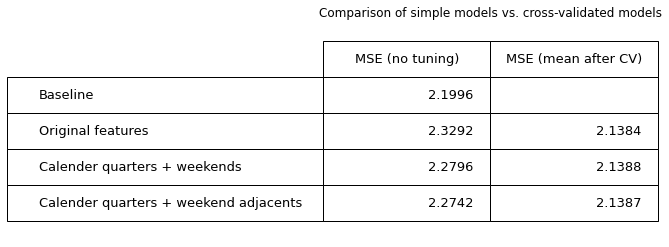

In [16]:
fig, ax = plt.subplots()
ax.axis('off')
plt.title("Comparison of simple models vs. cross-validated models")
table = ax.table(cellText=[[round(simple_comparison['baseline']['MSE'],4),' '],
    [round(simple_comparison[0]['MSE'],4),round(np.mean(model_scores[0]),4)],[round(simple_comparison[1]['MSE'],4),round(np.mean(model_scores[1]),4)], 
    [round(simple_comparison[2]['MSE'],4),round(np.mean(model_scores[2]),4)]], colLabels=['MSE (no tuning)','MSE (mean after CV)'] , 
    rowLabels=['Baseline', 'Original features', 'Calender quarters + weekends', 'Calender quarters + weekend adjacents'], loc='center')
table.set_fontsize(14)
table.scale(1,3)

With ridiculously high trade-off parameters all ridge regression models actually seem to predict a little more reliably. However, it remains unquestionable that the data are a) too little and b) too uninformative. I mean, I guess it's nice that most forest fires don't burn too big an area, but having that many 0.0ha burnt area is just weird for data that is supposed to be cases of fire.

Below you will find a collection of further ideas I would explore if I had more time and energy to invest in this project.

# Further ideas

- check feature importance
- try different solvers with GridSearch
- try other normalisation methods (eg. scikit-learns PowerTransformer)
- compare performance to other regression models
- gather more data with non-zero area values!!
- group area into area ranges for multi-class classification